In [1]:
import numpy as np
import torch
from IPython.display import Image

In [5]:
# data
# http://d2l-data.s3-accelerate.amazonaws.com/airfoil_self_noise.dat
data = np.genfromtxt('./airfoil_self_noise.dat', dtype=np.float32, delimiter='\t')
data.shape

(1503, 6)

In [6]:
data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0))

In [12]:
batch_size = 10
n_features = data.shape[1]-1
dataset = torch.utils.data.TensorDataset(data[:1500, :-1], data[:1500, -1])
data_loader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

## adadelta

In [15]:
torch.square(torch.tensor(2))

tensor(4)

In [13]:
def init_adadelta_states(n_features):
    s_w, s_b = torch.zeros((n_features, 1)), torch.zeros(1)
    delta_w, delta_b = torch.zeros((delta_w, 1)), torch.zeros(1)
    return (s_w, s_b), (delta_w, delta_b)

In [16]:
def adadelta_step(params, states, hyperparams):
    rho, eps = hyperparams['rho'], 1e-6
    for p, (s, delta) in zip(params, states):
        with torch.no_grad():
            s[:] = rho * s + (1-rho)*torch.square(p.grad)
            g = (torch.sqrt(delta + eps) / torch.sqrt(s + eps)) * p.grad
            p[:] -= g
            delta[:] = rho * delta + (1 - rho) * g * g
        p.grad.data.zero_()

In [17]:
def train(step_fn, states, hyperparams, data_loader, n_features, num_epochs=5):
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1),
                     requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    model = lambda X: torch.matmul(X, w) + b, 
    loss_fn = lambda y, y_hat: 1/2 * (y_hat - y) ** 2 
    

## Adam: Adaptive Moment Estimation

$$
\begin{split}
&m_0=0,v_0=0\\
&m_t=\beta_1m_{t-1}+(1-\beta_1)g_t\\
&v_t=\beta_2v_{t-1}+(1-\beta_2)g_t^2\\
&\hat {m}_t=\frac{m_t}{1-\beta_1^t}\\
&\hat {v}_t=\frac{v_t}{1-\beta_2^t}\\
&\theta_{t+1}=\theta_t-\frac{\eta \hat{m}_t}{\sqrt{\hat{v}_t}+\epsilon}
\end{split}
$$

- 自适应（adaptive）体现在每个参数（parameter）的学习率
    - $m_t$ <= Momentum
    - $v_t$ <= RMSprop
- 关于 $m_t, v_t$ 的计算，可以称之为 EMA（exponential moving average）
    - $m_t$ 是**过去所有梯度**的加权平均
    - $m_t=\beta_1^0(1-\beta_1)g_t+\beta_1^1(1-\beta_1)g_{t-1}+\beta_1^2(1-\beta_1)g_{t-2}+\cdots+\beta_1^{t-1}(1-\beta_1)g_1$
    - $(1-\beta_1)\gt \beta_1(1-\beta_1)\gt \beta_1^2(1-\beta_1)\gt\cdots\gt \beta_1^{t-1}(1-\beta_1)$
    - 越近（$t$ 越大）的梯度，对 update 的贡献更大；
    - 分析下各个时刻 $g_t$ 前的系数 $\beta^{t-1}(1-\beta)$
    
    $$
    \begin{split}
    &=\beta^0(1-\beta)+\beta^1(1-\beta)+\beta^2(1-\beta)+\cdots+\beta^{t-1}(1-\beta)\\
    &=(1-\beta)(\beta^0+\beta^1+\cdots+\beta^{t-1})\\
    &\approx(1-\beta)\frac{1}{1-\beta}\approx1
    \end{split}
    $$
    
- $\hat{m}_t$ is the bias-corrected（偏差校正） first moment (mean) estimate of the gradients.
    - $m_0=0$ => $m_t$ 在初始阶段被低估，$1/(1-\beta_1^t)$ 初始会进行比较大的更新，但随着 $t$ 的变大，分母越开越趋近于1
- $\hat{v}_t$ is the bias-corrected second moment (uncentered variance) estimate of the gradients.
- optimizer states 的角度
    - $m_t, v_t$ 都与 $g_t$ 与模型的参数量相同；$m_t,v_t$ 称之为 optimizer states
    - 模型的参数量为 $N$，$m, v$ 的大小分别也为 $N$；
    - deepseed ZeRO stage
- Adam tweaks the gradient descent method by considering the moving average of the first and second-order moments of the gradient.

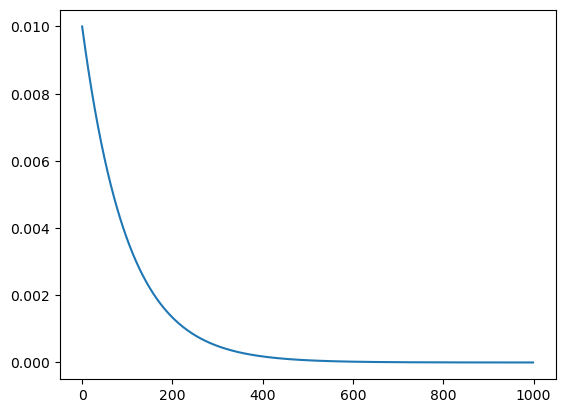

In [5]:
import numpy as np
import matplotlib.pyplot as plt

beta = 0.99
ts = np.arange(1000)
ys = [beta**t *(1-beta) for t in ts]
plt.plot(ts, ys)

/tmp/ipykernel_7860/1548271231.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  ys = [1./(1-beta**t) for t in ts]


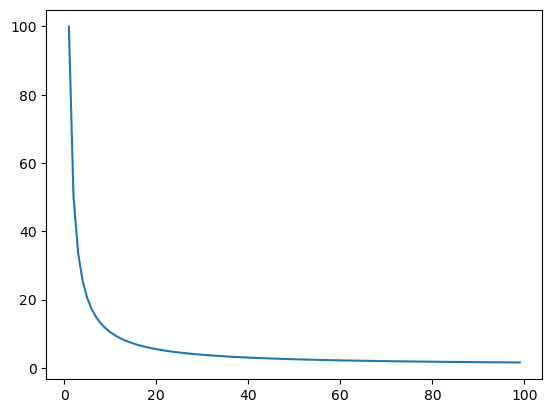

In [7]:
import numpy as np
import matplotlib.pyplot as plt

beta = 0.99
ts = np.arange(100)
ys = [1./(1-beta**t) for t in ts]
plt.plot(ts, ys)

In [4]:
Image(url='https://artemoppermann.com/wp-content/uploads/2021/08/image-56.png', width=400)

In [28]:
Image(url='https://www.microsoft.com/en-us/research/uploads/prod/2020/02/DeepSpeed-Image-1.png', width=700)

## Adam => AdamW

- https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam
- https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html